In [128]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

(100, 100)


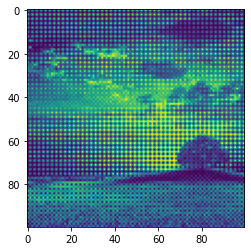

In [108]:
bayerImg = np.load('BayerImage.npy')
print(bayerImg.shape)
plt.imshow(bayerImg)
plt.show()

In [109]:
def get3x5(img, i, j):
    return img[ i-1: i+2, j-2 : j+3]

In [110]:
def getDH_DV_TD(temp):
    Regs3x5 = temp.astype(int)
    # print(Regs3x5.shape)
    DV = abs(Regs3x5[0, 1] - Regs3x5[2, 1]) + abs(Regs3x5[0, 2] - Regs3x5[2, 2]) + abs(Regs3x5[0, 3] - Regs3x5[2, 3])

    DH = abs(Regs3x5[0, 1] - Regs3x5[0, 3]) + abs(Regs3x5[1, 1] - Regs3x5[1, 3]) + abs(Regs3x5[2, 1] - Regs3x5[2, 3])

    TD = DV + DH

    return {'DV' : DV, 'DH' : DH, 'TD' : TD}

In [135]:
def GInterpolator_eq(temp, EdgeVals):
    Regs3x5 =  temp.astype(int)
    # equation 4,5,6
    G_1 = ((3.0/8.0) * ( Regs3x5[1, 1] + Regs3x5[1, 3] )) +\
          ((1.0/8.0) * ( Regs3x5[0, 2] + Regs3x5[2, 2] )) -\
          ((1.0/4.0) * ( Regs3x5[1, 0] + Regs3x5[1, 4] )) +\
          (1.0/2.0) * Regs3x5[1, 2]   
    G_2 = ((1.0/2.0) * ( Regs3x5[1, 1] + Regs3x5[1, 3] )) -\
          ((1.0/4.0) * ( Regs3x5[1, 0] + Regs3x5[1, 4] )) +\
          (1.0/2.0) * Regs3x5[1, 2]   
    G_3 = ((1.0/8.0) * ( Regs3x5[1, 1] + Regs3x5[1, 3] )) +\
          ((3.0/8.0) * ( Regs3x5[0, 2] + Regs3x5[2, 2] )) -\
          ((1.0/8.0) * ( Regs3x5[1, 0] + Regs3x5[1, 4] )) +\
          (1.0/4.0) * Regs3x5[1, 2]   

    if EdgeVals['DV'] == EdgeVals['DH']:
        return math.floor(G_1)
    if EdgeVals['DV'] > EdgeVals['DH']:
        return math.floor(G_2)
    if EdgeVals['DV'] < EdgeVals['DH']:
        return math.floor(G_3)

In [308]:
def GInterpolator_logic(temp, EdgeVals):
    Regs3x5 = temp.astype(int)
    # print(Regs3x5.shape)
    S1a1 = Regs3x5[0, 2] + Regs3x5[2, 2]
    S1a2 = Regs3x5[1, 1] + Regs3x5[1, 3]
    S1a3 = Regs3x5[1, 0] + Regs3x5[1, 4]
    S1a4 = Regs3x5[1, 2]

    S1sh1 = S1a1*2
    S1sh2 = S1a2*2
    S1sh3 = S1a4*2

    S2a1 = S1a1 + S1sh1
    S2a2 = S1a2 + S1sh2
    S2a3 = S1sh3 - S1a3

    if EdgeVals['DH'] == EdgeVals['DV']:
        S1m1 = S1a1
    elif DH > DV:
        S1m1 = S2a1
    else:
        S1m1 = 0

    if EdgeVals['DH'] == EdgeVals['DV']:
        S1m2 = S2a2
    else:
        S1m2 = S1a2
    
    S3sh1 = S2a3 * 2

    S3a1 = S1m1 + S1m2
    S3a2 = S1a2 + S2a2

    if EdgeVals['DH'] < EdgeVals['DV']:
        S2m1 = S3a2
    else:
        S2m1 = S3a1
    
    if EdgeVals['DH'] > EdgeVals['DV']:
        S2m2 = S2a3
    else:
        S2m2 = S3sh1
    
    Fa = S2m1 + S2m2 

    return(Fa>>3)

In [309]:
def RB_inpAtBR_eq_M1(temp, EdgeVals, Gupdated):
    Regs3x5 = temp.astype(int)

    RB_1 = ((1.0/4.0) * (Regs3x5[0, 1] + Regs3x5[0, 3] + Regs3x5[2, 1] + Regs3x5[2, 3])) +\
           (Gupdated) -\
           ((1.0/4.0) * (Regs3x5[0, 2] + Regs3x5[2, 2] + Regs3x5[1, 1] + Regs3x5[1, 3]))
    
    RB_2 = ((1.0/4.0) * (Regs3x5[0, 1] + Regs3x5[0, 3] + Regs3x5[2, 1] + Regs3x5[2, 3])) +\
           (Gupdated) -\
           ((1.0/8.0) * (3*(Regs3x5[0, 2] + Regs3x5[2, 2]) + Regs3x5[1, 1] + Regs3x5[1, 3]))
    RB_3 = ((1.0/4.0) * (Regs3x5[0, 1] + Regs3x5[0, 3] + Regs3x5[2, 1] + Regs3x5[2, 3])) +\
           (Gupdated) -\
           ((1.0/8.0) * (Regs3x5[0, 2] + Regs3x5[2, 2] + 3*(Regs3x5[1, 1] + Regs3x5[1, 3])))
    # print(RB_1, RB_2, RB_3)
    if EdgeVals['DV'] == EdgeVals['DH']:
        return math.floor(RB_1)
    if EdgeVals['DV'] < EdgeVals['DH']:
        return math.floor(RB_2)
    if EdgeVals['DV'] > EdgeVals['DH']:
        return math.floor(RB_3)
           

In [310]:
def RB_inpAtBR_logic_M1(temp, EdgeVals, Gupdated):
    Regs3x5 = temp.astype(int)
    S1a1 = Regs3x5[0, 1] + Regs3x5[2, 1]
    S1a2 = Regs3x5[0, 3] + Regs3x5[2, 3]
    S1a3 = Regs3x5[0, 2] + Regs3x5[2, 2]
    S1a4 = Regs3x5[1, 3] + Regs3x5[1, 1]

    S2a1 = S1a1 + S1a2
    S2sh2 = S1a3*2
    S2a3 = S1a3 + S1a4
    S2sh4 = S1a4*2

    S3sh1 = S2a1 / 4.0
    S3sh2 = S2a3 * 2
    S3a3 = S2sh2 + S2a3
    S3a4 = S2a3 +S2sh4

    if EdgeVals['DV'] < EdgeVals['DH']:
        M1 = S3a3
    elif EdgeVals['DV'] > EdgeVals['DH']:
        M1 = S3a4
    else:
        M1 = 0
    

    if EdgeVals['DV'] == EdgeVals['DH']:
        M2 = S3sh2
    else:
        M2 = M1
    
    M2 = M2>>3

    Gadder = Gupdated + S3sh1

    return math.floor(Gadder - M2)
    

In [311]:
def RB_InpAtG_M2_eq(temp,):
    Regs3x5 = temp.astype(int)
    retVal = ((1.0/2.0) * (Regs3x5[0, 2] + Regs3x5[2, 2])) +\
           ((1.0/2.0) * Regs3x5[1, 2]) -\
           ((1.0/8.0) * (Regs3x5[0, 1] + Regs3x5[0, 3] + Regs3x5[2, 1]+ Regs3x5[2, 3]))
    return math.floor(retVal)
def RB_InpAtG_M2_logic(temp):
    Regs3x5 = temp.astype(int)
    Cadd = Regs3x5[0, 1] + Regs3x5[2, 1] + Regs3x5[0, 3] + Regs3x5[2, 3]
    Sh1 = (Regs3x5[0, 2] + Regs3x5[2, 2])/2
    Sh2 = Regs3x5[1, 2]/2
    A2 = Sh1 + Sh2
    Sh2 = Cadd/8
    return math.floor(A2 - Sh2)

In [312]:
def RB_InpAtG_M3_eq(temp,):
    Regs3x5 = temp.astype(int)
    a1 = 0.5 * (Regs3x5[1, 3] + Regs3x5[1, 1])
    return math.floor(a1)


def RB_InpAtG_M3_logic(temp,):
    Regs3x5 = temp.astype(int)
    a1 = Regs3x5[1, 3] + Regs3x5[1, 1]
    sh = a1/2
    return math.floor(sh)

In [313]:
bayerImg[:10,:10]

array([[158,  22, 153,  19, 160,  19, 166,  20, 170,  24],
       [ 21,   0,  20,   1,  21,   3,  21,   2,  20,   1],
       [164,  23, 172,  22, 169,  24, 173,  23, 178,  22],
       [ 21,   2,  20,   1,  22,   1,  20,   1,  20,   0],
       [168,  21, 169,  19, 169,  17, 174,  21, 176,  20],
       [ 21,   0,  19,   2,  15,   0,  18,   0,  18,   1],
       [147,  15, 150,  14, 152,  15, 156,  13, 164,  19],
       [ 16,   0,  16,   1,  15,   0,  19,   1,  18,   3],
       [147,  16, 156,  20, 149,  20, 160,  22, 171,  16],
       [ 13,   2,  12,   1,  13,   2,  19,   1,  21,   0]], dtype=uint8)

In [314]:
bayerImg.shape[1]-2

98

In [315]:
reconstructedImage = np.zeros((bayerImg.shape[0]-2, bayerImg.shape[1]-4, 3))

for i in range(1, bayerImg.shape[0]-1):
    for j in range(2, bayerImg.shape[1]-2):
        Regs3x5 = get3x5(bayerImg, i, j)
        EdgeVals = getDH_DV_TD(Regs3x5)
        Gout = GInterpolator_logic(Regs3x5, EdgeVals)
        RBfromM1 = RB_inpAtBR_logic_M1(Regs3x5, EdgeVals, Gout)
        RBfromM2 = RB_InpAtG_M2_logic(Regs3x5)
        RBfromM3 = RB_InpAtG_M3_logic(Regs3x5)

        if (i%2 == 0) and (j%2 == 0):# Blue Color -- Even i's and even j's
            Rfinal = RBfromM1
            Gfinal = Gout
            Bfinal = Regs3x5[1, 2]
        elif (i%2 == 1) and (j%2 == 1):# Red Color -- Odd i's and odd j's
            Rfinal = Regs3x5[1, 2]
            Gfinal = Gout
            Bfinal = RBfromM1
        elif (i%2 == 0) and (j%2 == 1):# Green Color (BGBG...) -- Even i's and odd j's
            Rfinal = RBfromM2
            Gfinal = Regs3x5[1, 2]
            Bfinal = RBfromM3
        elif (i%2 == 1) and (j%2 == 0):# Green Color (GRGR...) -- Odd i's and even j's
            Rfinal = RBfromM3
            Gfinal = Regs3x5[1, 2]
            Bfinal = RBfromM2
        pixVal = np.array([Rfinal, Gfinal, Bfinal])
        reconstructedImage[i-1, j-2] = pixVal

(98, 96, 3)


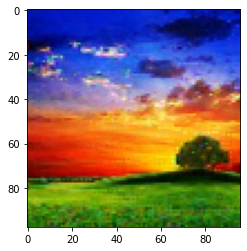

In [353]:
print(reconstructedImage.shape)
imgSH = reconstructedImage.copy()
imgSH[imgSH<0] = 0
imgSH[imgSH>255] = 255
imgSH = imgSH.astype(np.uint8)
plt.imshow(imgSH)
plt.show()

plt.imsave('ReconstructionImageWithoutPadding.png', imgSH)

In [350]:
HP = np.zeros((1, bayerImg.shape[1]))
WP = np.zeros((bayerImg.shape[0]+2, 2))
bayerImgPadded = np.concatenate((HP, bayerImg, HP))
bayerImgPadded = np.hstack((WP, bayerImgPadded, WP))


reconstructedImageWithPadding = np.zeros((bayerImg.shape[0], bayerImg.shape[1], 3))


print(bayerImg.shape, bayerImgPadded.shape)
for i in range(1, bayerImgPadded.shape[0]-1):
    for j in range(2, bayerImgPadded.shape[1]-2):
        Regs3x5 = get3x5(bayerImgPadded, i, j)
        EdgeVals = getDH_DV_TD(Regs3x5)
        Gout = GInterpolator_logic(Regs3x5, EdgeVals)
        RBfromM1 = RB_inpAtBR_logic_M1(Regs3x5, EdgeVals, Gout)
        RBfromM2 = RB_InpAtG_M2_logic(Regs3x5)
        RBfromM3 = RB_InpAtG_M3_logic(Regs3x5)

        if (i%2 == 1) and (j%2 == 0):# Blue Color -- Odd i's and even j's
            Rfinal = RBfromM1
            Gfinal = Gout
            Bfinal = Regs3x5[1, 2]
        elif (i%2 == 0) and (j%2 == 1):# Red Color -- Even i's and odd j's
            Rfinal = Regs3x5[1, 2]
            Gfinal = Gout
            Bfinal = RBfromM1
        elif (i%2 == 1) and (j%2 == 1):# Green Color (BGBG...) -- Odd i's and odd j's
            Rfinal = RBfromM2
            Gfinal = Regs3x5[1, 2]
            Bfinal = RBfromM3
        elif (i%2 == 2) and (j%2 == 0):# Green Color (GRGR...)-- Even i's and even j's
            Rfinal = RBfromM3
            Gfinal = Regs3x5[1, 2]
            Bfinal = RBfromM2
        pixVal = np.array([Rfinal, Gfinal, Bfinal])
        reconstructedImageWithPadding[i-1, j-2] = pixVal

(100, 100) (102, 104)


(100, 100, 3)


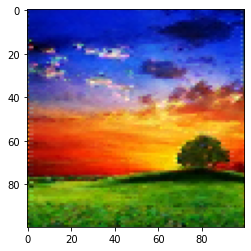

In [354]:
print(reconstructedImageWithPadding.shape)
imgSH = reconstructedImageWithPadding.copy()
imgSH[imgSH<0] = 0
imgSH[imgSH>255] = 255
imgSH = imgSH.astype(np.uint8)
plt.imshow(imgSH)
plt.show()

plt.imsave('ReconstructionImageWithPadding.png', imgSH)